In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk import bigrams
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

C:\Users\herik\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Ambiente

In [2]:
seed_ = 194
np.random.seed(seed_)

## Carregando e tratando base de dados

In [3]:
df = pd.read_csv('data/df_sem_duplicatas.csv')

In [4]:
df.head()

,descricao,categoria
0,caneta bic cristal,Papelaria
1,caneta bps pilot,Papelaria
2,caneta marcador permanente acrilex ponta dupla,Papelaria
3,caneta retocar madeira branco corcel,Papelaria
4,caneta retroprojetor manter fazer castelo pont...,Papelaria


In [5]:
# Carregando LabelEncoder model
pkl_file = open('models/label_encoder.pkl', 'rb')
le = pickle.load(pkl_file) 
pkl_file.close()

In [6]:
le.fit(df['categoria'])
df['categoria'] = le.transform(df['categoria'])

In [7]:
# Salvando LabelEncoder model

#output = open('models/label_encoder.pkl', 'wb')
#pickle.dump(le, output)
#output.close()

In [8]:
# Capturando targets gerados pelo LabelEncoder
target_names = le.classes_

In [9]:
df.head()

,descricao,categoria
0,caneta bic cristal,3
1,caneta bps pilot,3
2,caneta marcador permanente acrilex ponta dupla,3
3,caneta retocar madeira branco corcel,3
4,caneta retroprojetor manter fazer castelo pont...,3


## Separando em treino/teste e vetorizando por bigram

In [10]:
# Separa em treino e teste
X = df['descricao']
y = df['categoria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed_)

In [11]:
# Realiza contagem de token com bigram
vectorizer = CountVectorizer(ngram_range = (2, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Modelagem Naive Bayes

In [12]:
def report_modelo(modelo, y, pred):
    print("Acurácia: %f" % accuracy_score(y_true = y, y_pred = pred))
    
    # Plotando a matriz de confusão
    cm = confusion_matrix(y, pred)
    cm = pd.DataFrame(cm, index = target_names, columns = target_names)

    plt.figure(figsize = (8, 8))
    sns.heatmap(cm, cmap = "Blues", linecolor = 'black', linewidths = 1, annot = True, \
                fmt = '', xticklabels = target_names, yticklabels = target_names)
    plt.show()
    
    # Imprimindo métricas
    print(classification_report(y_true = y, y_pred = pred, target_names= target_names))

In [13]:
def treinaClassificacao_GridSearchCV(modelo, params_, x_treino, y_treino, x_teste, y_teste,\
                        n_jobs = -1, cv = 5, refit = True, scoring = None, salvar_resultados = False,\
                       report_treino = False, retorna_modelo = False):
    
    # Realizando treinamento baseado no grid informado
    grid = GridSearchCV(modelo, params_, n_jobs = n_jobs, cv = cv, refit = refit, scoring = scoring)
    
    grid.fit(x_treino, y_treino)
    pred = grid.predict(x_teste)
    modelo_ = grid.best_estimator_

    print(grid.best_params_)
    
    # Realizando previsões
    y_test_pred = modelo_.predict(x_teste)
    
    # Gerando report do modelo
    report_modelo(modelo_, y_teste, y_test_pred) 
    
    # Salvando resultados em dataframe caso solicitado
    if salvar_resultados:
        resultados_df = pd.DataFrame(grid.cv_results_)
        
        if retorna_modelo:
            return resultados_df, modelo_
        else:
            resultados_df
        
    if retorna_modelo:
        return modelo_

## Molelo Base Naive Bayes Bigram

In [14]:
# Instancia modelo base
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

MultinomialNB()

Acurácia: 0.889552


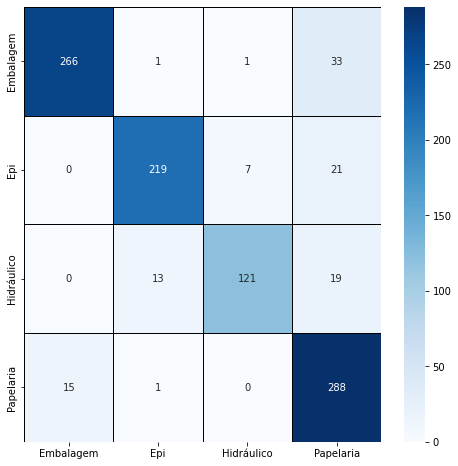

              precision    recall  f1-score   support

   Embalagem       0.95      0.88      0.91       301
         Epi       0.94      0.89      0.91       247
  Hidráulico       0.94      0.79      0.86       153
   Papelaria       0.80      0.95      0.87       304

    accuracy                           0.89      1005
   macro avg       0.90      0.88      0.89      1005
weighted avg       0.90      0.89      0.89      1005



In [15]:
# Realiza previsões e imprime report
y_pred = nb_classifier.predict(X_test_vec)
report_modelo(nb_classifier, y_test, y_pred) 

## Tuning Naive Bayes Bigram

{'alpha': 0.0, 'fit_prior': True}
Acurácia: 0.888557


C:\Users\herik\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


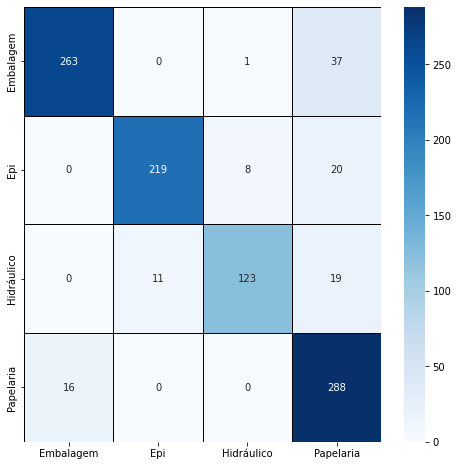

              precision    recall  f1-score   support

   Embalagem       0.94      0.87      0.91       301
         Epi       0.95      0.89      0.92       247
  Hidráulico       0.93      0.80      0.86       153
   Papelaria       0.79      0.95      0.86       304

    accuracy                           0.89      1005
   macro avg       0.90      0.88      0.89      1005
weighted avg       0.90      0.89      0.89      1005

CPU times: total: 2.83 s
Wall time: 8.75 s


In [16]:
%%time

params = {
    'alpha': [i * 0.001 for i in range(1000)],
    'fit_prior': [True, False]
}

# Tuning Naibe Nayes
modelo_nb = MultinomialNB()

modelo_nb = treinaClassificacao_GridSearchCV(modelo_nb, params, X_train_vec, y_train,\
                                              X_test_vec, y_test)

In [17]:
# Salvando modelo como pickle
with open('models/naive_bayes_bigram.pkl', 'wb') as model_file:
    pickle.dump(nb_classifier, model_file)

## Vetorizando por Trigram

In [18]:
# Realiza contagem de token com trigram
vectorizer = CountVectorizer(ngram_range = (3, 3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Molelo Base Naive Bayes Trigram

In [19]:
# Instancia modelo base
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

MultinomialNB()

Acurácia: 0.745274


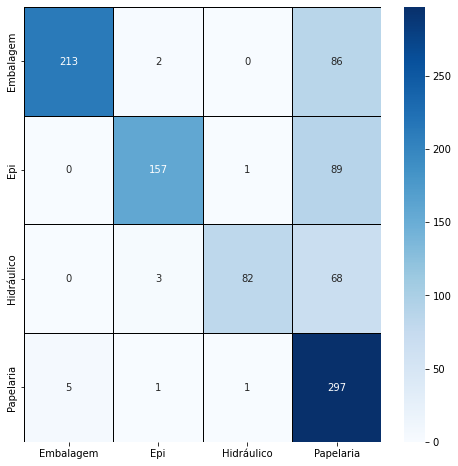

              precision    recall  f1-score   support

   Embalagem       0.98      0.71      0.82       301
         Epi       0.96      0.64      0.77       247
  Hidráulico       0.98      0.54      0.69       153
   Papelaria       0.55      0.98      0.70       304

    accuracy                           0.75      1005
   macro avg       0.87      0.71      0.75      1005
weighted avg       0.84      0.75      0.75      1005



In [20]:
# Realiza previsões e imprime report
y_pred = nb_classifier.predict(X_test_vec)
report_modelo(nb_classifier, y_test, y_pred) 

## Tuning Naive Bayes Trigram

{'alpha': 0.0, 'fit_prior': True}
Acurácia: 0.755224


C:\Users\herik\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


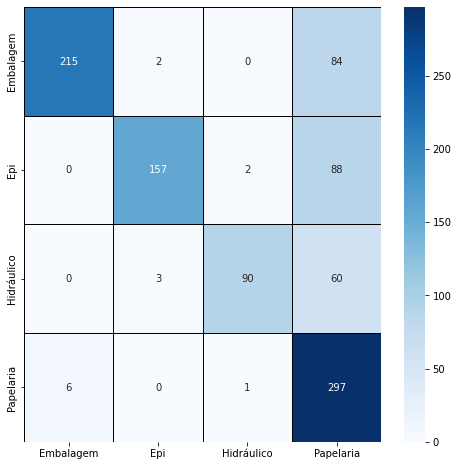

              precision    recall  f1-score   support

   Embalagem       0.97      0.71      0.82       301
         Epi       0.97      0.64      0.77       247
  Hidráulico       0.97      0.59      0.73       153
   Papelaria       0.56      0.98      0.71       304

    accuracy                           0.76      1005
   macro avg       0.87      0.73      0.76      1005
weighted avg       0.85      0.76      0.76      1005

CPU times: total: 2.56 s
Wall time: 3.85 s


In [21]:
%%time

params = {
    'alpha': [i * 0.001 for i in range(1000)],
    'fit_prior': [True, False]
}

# Tuning Naibe Nayes
modelo_nb = MultinomialNB()

modelo_nb = treinaClassificacao_GridSearchCV(modelo_nb, params, X_train_vec, y_train,\
                                              X_test_vec, y_test)

In [22]:
# Salvando modelo como pickle
with open('models/naive_bayes_trigram.pkl', 'wb') as model_file:
    pickle.dump(nb_classifier, model_file)

## Vetorizando por Texto

In [23]:
# Realiza contagem de token com trigram
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Molelo Base Naive Bayes

In [24]:
# Instancia modelo base
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

MultinomialNB()

Acurácia: 0.896517


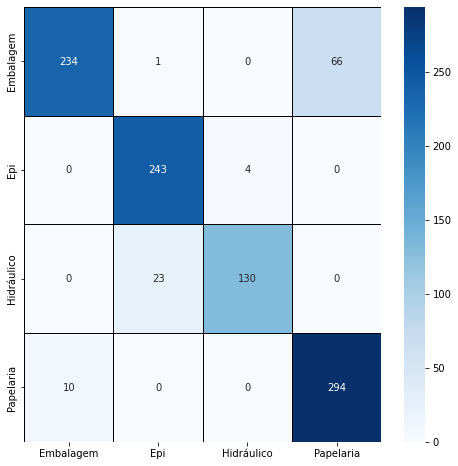

              precision    recall  f1-score   support

   Embalagem       0.96      0.78      0.86       301
         Epi       0.91      0.98      0.95       247
  Hidráulico       0.97      0.85      0.91       153
   Papelaria       0.82      0.97      0.89       304

    accuracy                           0.90      1005
   macro avg       0.91      0.89      0.90      1005
weighted avg       0.91      0.90      0.90      1005



In [25]:
# Realiza previsões e imprime report
y_pred = nb_classifier.predict(X_test_vec)
report_modelo(nb_classifier, y_test, y_pred) 

## Tuning Naive Bayes

{'alpha': 0.002, 'fit_prior': False}
Acurácia: 0.911443


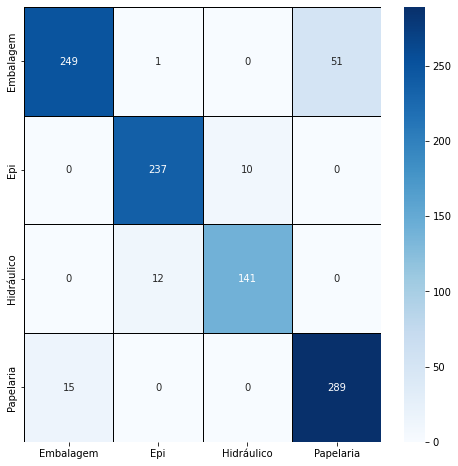

              precision    recall  f1-score   support

   Embalagem       0.94      0.83      0.88       301
         Epi       0.95      0.96      0.95       247
  Hidráulico       0.93      0.92      0.93       153
   Papelaria       0.85      0.95      0.90       304

    accuracy                           0.91      1005
   macro avg       0.92      0.91      0.92      1005
weighted avg       0.91      0.91      0.91      1005

CPU times: total: 2.11 s
Wall time: 2.35 s


In [26]:
%%time

params = {
    'alpha': [i * 0.001 for i in range(1000)],
    'fit_prior': [True, False]
}

# Tuning Naibe Nayes
modelo_nb = MultinomialNB()

modelo_nb = treinaClassificacao_GridSearchCV(modelo_nb, params, X_train_vec, y_train,\
                                              X_test_vec, y_test)

In [27]:
# Salvando modelo como pickle
with open('models/naive_bayes.pkl', 'wb') as model_file:
    pickle.dump(nb_classifier, model_file)

In [28]:
# Salvando count vectorizer como pickle
with open('models/countvectorizer_naive_bayes.pkl', 'wb') as model_file:
    pickle.dump(vectorizer, model_file)